# occupancy prediction - forecasting using ARIMA model

> Author: Trevor Bergstrom <br>
> Date: 2022-08-27 <br>
> Kernel: Python 3.10 <br>

## init

In [1]:
import os 
os.chdir('/Users/trevor/Work/1-projects/occupancy-prediction')

import numpy as np
import pandas as pd 
import pathlib 

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
DATASTORE = pathlib.Path('datastore')
assert DATASTORE.exists(), f'unable to find datastore at: {DATASTORE}'

# data acquisition

## load

In [12]:
data_path = DATASTORE.joinpath('occ-counts.csv')

df = (
    pd.read_csv(data_path, parse_dates=['timestamp']).rename(columns={'count': 'occ'})
    .query('location == "POP"')
    .query('5 < timestamp.dt.hour < 24')
    .drop(columns=['location', 'capacity', 'subLabel', 'lastUpdate'])
    .reindex(columns=['timestamp', 'occ'])
)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7160 entries, 0 to 22647
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7160 non-null   datetime64[ns]
 1   occ        7160 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 167.8 KB


None

,timestamp,occ
0,2022-03-28 16:02:42.738457,177
3,2022-03-28 16:04:30.367773,184
6,2022-03-28 16:04:53.611084,191
9,2022-03-28 16:11:59.003963,207
12,2022-03-28 16:22:04.569012,227


## feature processing

In [49]:
occs = (
    df
    # resample daily
    .groupby(pd.Grouper(key='timestamp', freq='1D')).occ.mean()
    .fillna(0).reset_index()
    # skip past section of missing data
    .loc[lambda d: d.timestamp >= pd.to_datetime('2022-05-01')]
)
occs.head()

,timestamp,occ
34,2022-05-01,169.318182
35,2022-05-02,129.600000
36,2022-05-03,139.976744
37,2022-05-04,129.476190
38,2022-05-05,137.695652


In [50]:
cutover = pd.to_datetime('2022-07-15')
occs_train = occs.loc[lambda d: d.timestamp <= cutover]
occs_test = occs.loc[lambda d: d.timestamp > cutover]

# ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA

## train

In [52]:
orig = occs_train.set_index('timestamp').occ

model = ARIMA(orig, order=(2, 1, 2), freq='D')
results = model.fit()

/Users/trevor/Work/1-projects/occupancy-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/trevor/Work/1-projects/occupancy-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/trevor/Work/1-projects/occupancy-prediction/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:xlabel='timestamp'>

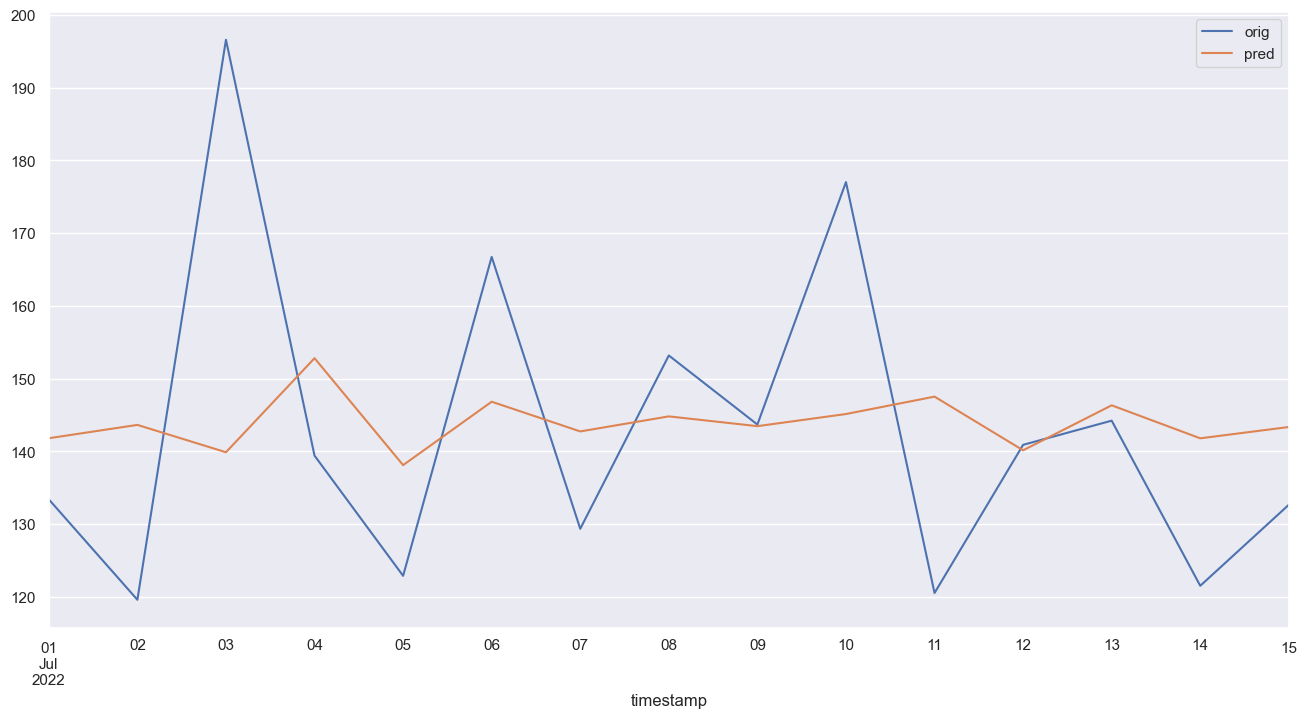

In [53]:
start = '2022-07-01'

pred_df = (
    pd.DataFrame({
        'orig': orig,
        'pred': results.fittedvalues,
    })
)
pred_df.loc[start:].plot(figsize=(16, 8))

In [54]:
((pred_df.orig - pred_df.pred)**2).sum()

94854.87609100976

In [55]:
results.predict(start='2022-07-15', end='2022-08-01')

2022-07-15    143.361557
2022-07-16    141.475670
2022-07-17    144.955384
2022-07-18    142.458235
2022-07-19    144.822436
2022-07-20    142.630673
2022-07-21    144.665447
2022-07-22    142.776598
2022-07-23    144.529999
2022-07-24    142.902334
2022-07-25    144.413279
2022-07-26    143.010684
2022-07-27    144.312699
2022-07-28    143.104051
2022-07-29    144.226027
2022-07-30    143.184508
2022-07-31    144.151340
2022-08-01    143.253840
Freq: D, Name: predicted_mean, dtype: float64